# 가설 검증

## 문제 정의
- **소수의 고객만이 google merchandise store의 수익에 기여하고 있다.**

## 가설 설정
1. 결제 단계에서 유저가 가장 많이 이탈할 것이다.
2. 유료 광고 트래픽 사용자는 Organic보다 구매율이 낮을 것이다.
3. 첫 방문자는 재방문자보다 전환율이 낮을 것이다.
4. 저녁/주말에는 전환율이 높을 것이다.
5. 장바구니에 상품을 추가하고 구매를 하지 않은 사람이 많을 것이다.
6. 모바일 사용자보다 데스크타비 사용자의 전환율이 높을 것이다.

In [1]:
import os
import ast
import json
import pickle
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

color = sns.color_palette()
%matplotlib inline

- 데이터 로드

In [2]:
def load_df(csv_path):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']

    df = pd.read_csv(csv_path,
                     converters={column: json.loads for column in JSON_COLUMNS},
                     dtype={'fullVisitorId': 'str'} # Important!!
                    )

    for column in JSON_COLUMNS:
        column_as_df = pd.json_normalize(df[column])  # ✅ 최신 방식 적용
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)

    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

df = load_df('/Volumes/Expansion/google_analytics_customer/new_train.csv')
df.head()

Loaded new_train.csv. Shape: (903653, 60)


,channelGrouping,customDimensions,date,fullVisitorId,hits,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,...,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.referralPath,trafficSource.keyword,trafficSource.adContent,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.campaignCode
0,Direct,"[{'index': '4', 'value': 'North America'}]",20160801,6849420071276447389,"[{'hitNumber': '1', 'time': '0', 'hour': '10',...",Not Socially Engaged,1470074045,1,1470074045,Safari,...,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Referral,"[{'index': '4', 'value': 'North America'}]",20160801,1231590494443171080,"[{'hitNumber': '1', 'time': '0', 'hour': '8', ...",Not Socially Engaged,1470067091,2,1470067091,Chrome,...,not available in demo dataset,/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Direct,"[{'index': '4', 'value': 'North America'}]",20160801,6751290259214798595,"[{'hitNumber': '1', 'time': '0', 'hour': '6', ...",Not Socially Engaged,1470056945,1,1470056945,Chrome,...,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Referral,"[{'index': '4', 'value': 'North America'}]",20160801,3213840074316400693,"[{'hitNumber': '1', 'time': '0', 'hour': '6', ...",Not Socially Engaged,1470057237,2,1470057237,Chrome,...,not available in demo dataset,/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Referral,"[{'index': '4', 'value': 'North America'}]",20160801,2987126973357946088,"[{'hitNumber': '1', 'time': '0', 'hour': '21',...",Not Socially Engaged,1470112710,1,1470112710,Chrome,...,not available in demo dataset,/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- hits 컬럼에 대한 분석을 위한 데이터 로드

In [30]:
pkl_paths = [f"/Volumes/Expansion/google_analytics_customer/funnel_batch_df_{i}.pkl" for i in range(9)]

# 각 Pickle 파일을 변수에 저장
batch_dfs = []
for i, path in enumerate(pkl_paths, start=1):
    with open(path, "rb") as f:
        batch_dfs.append(pickle.load(f))

# 변수명 자동 할당
batch_1_df, batch_2_df, batch_3_df, \
batch_4_df, batch_5_df, batch_6_df, \
batch_7_df, batch_8_df, batch_9_df = batch_dfs

## 1. 결제 단계에서 유저가 가장 많이 이탈할 것이다.
- 주요 지표 : `hits.eCommerceAction.action_type`

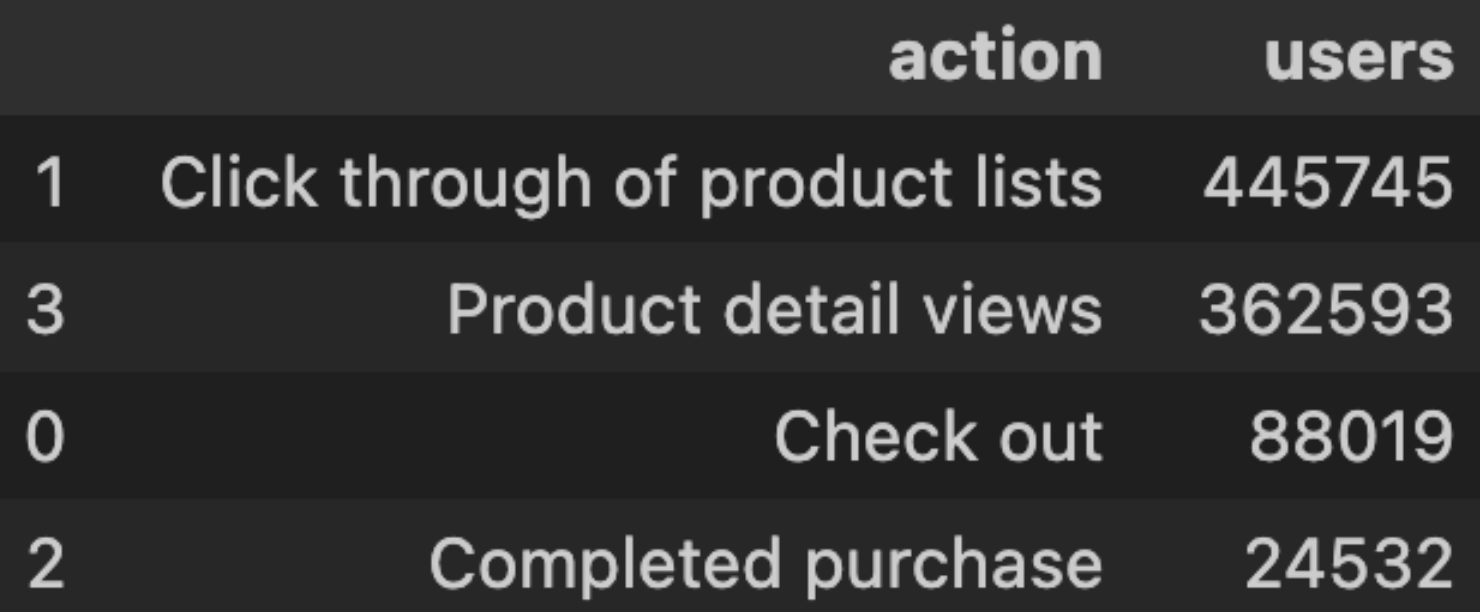

![스크린샷 2025-03-23 오후 5.34.51.png](<attachment:스크린샷 2025-03-23 오후 5.34.51.png>)
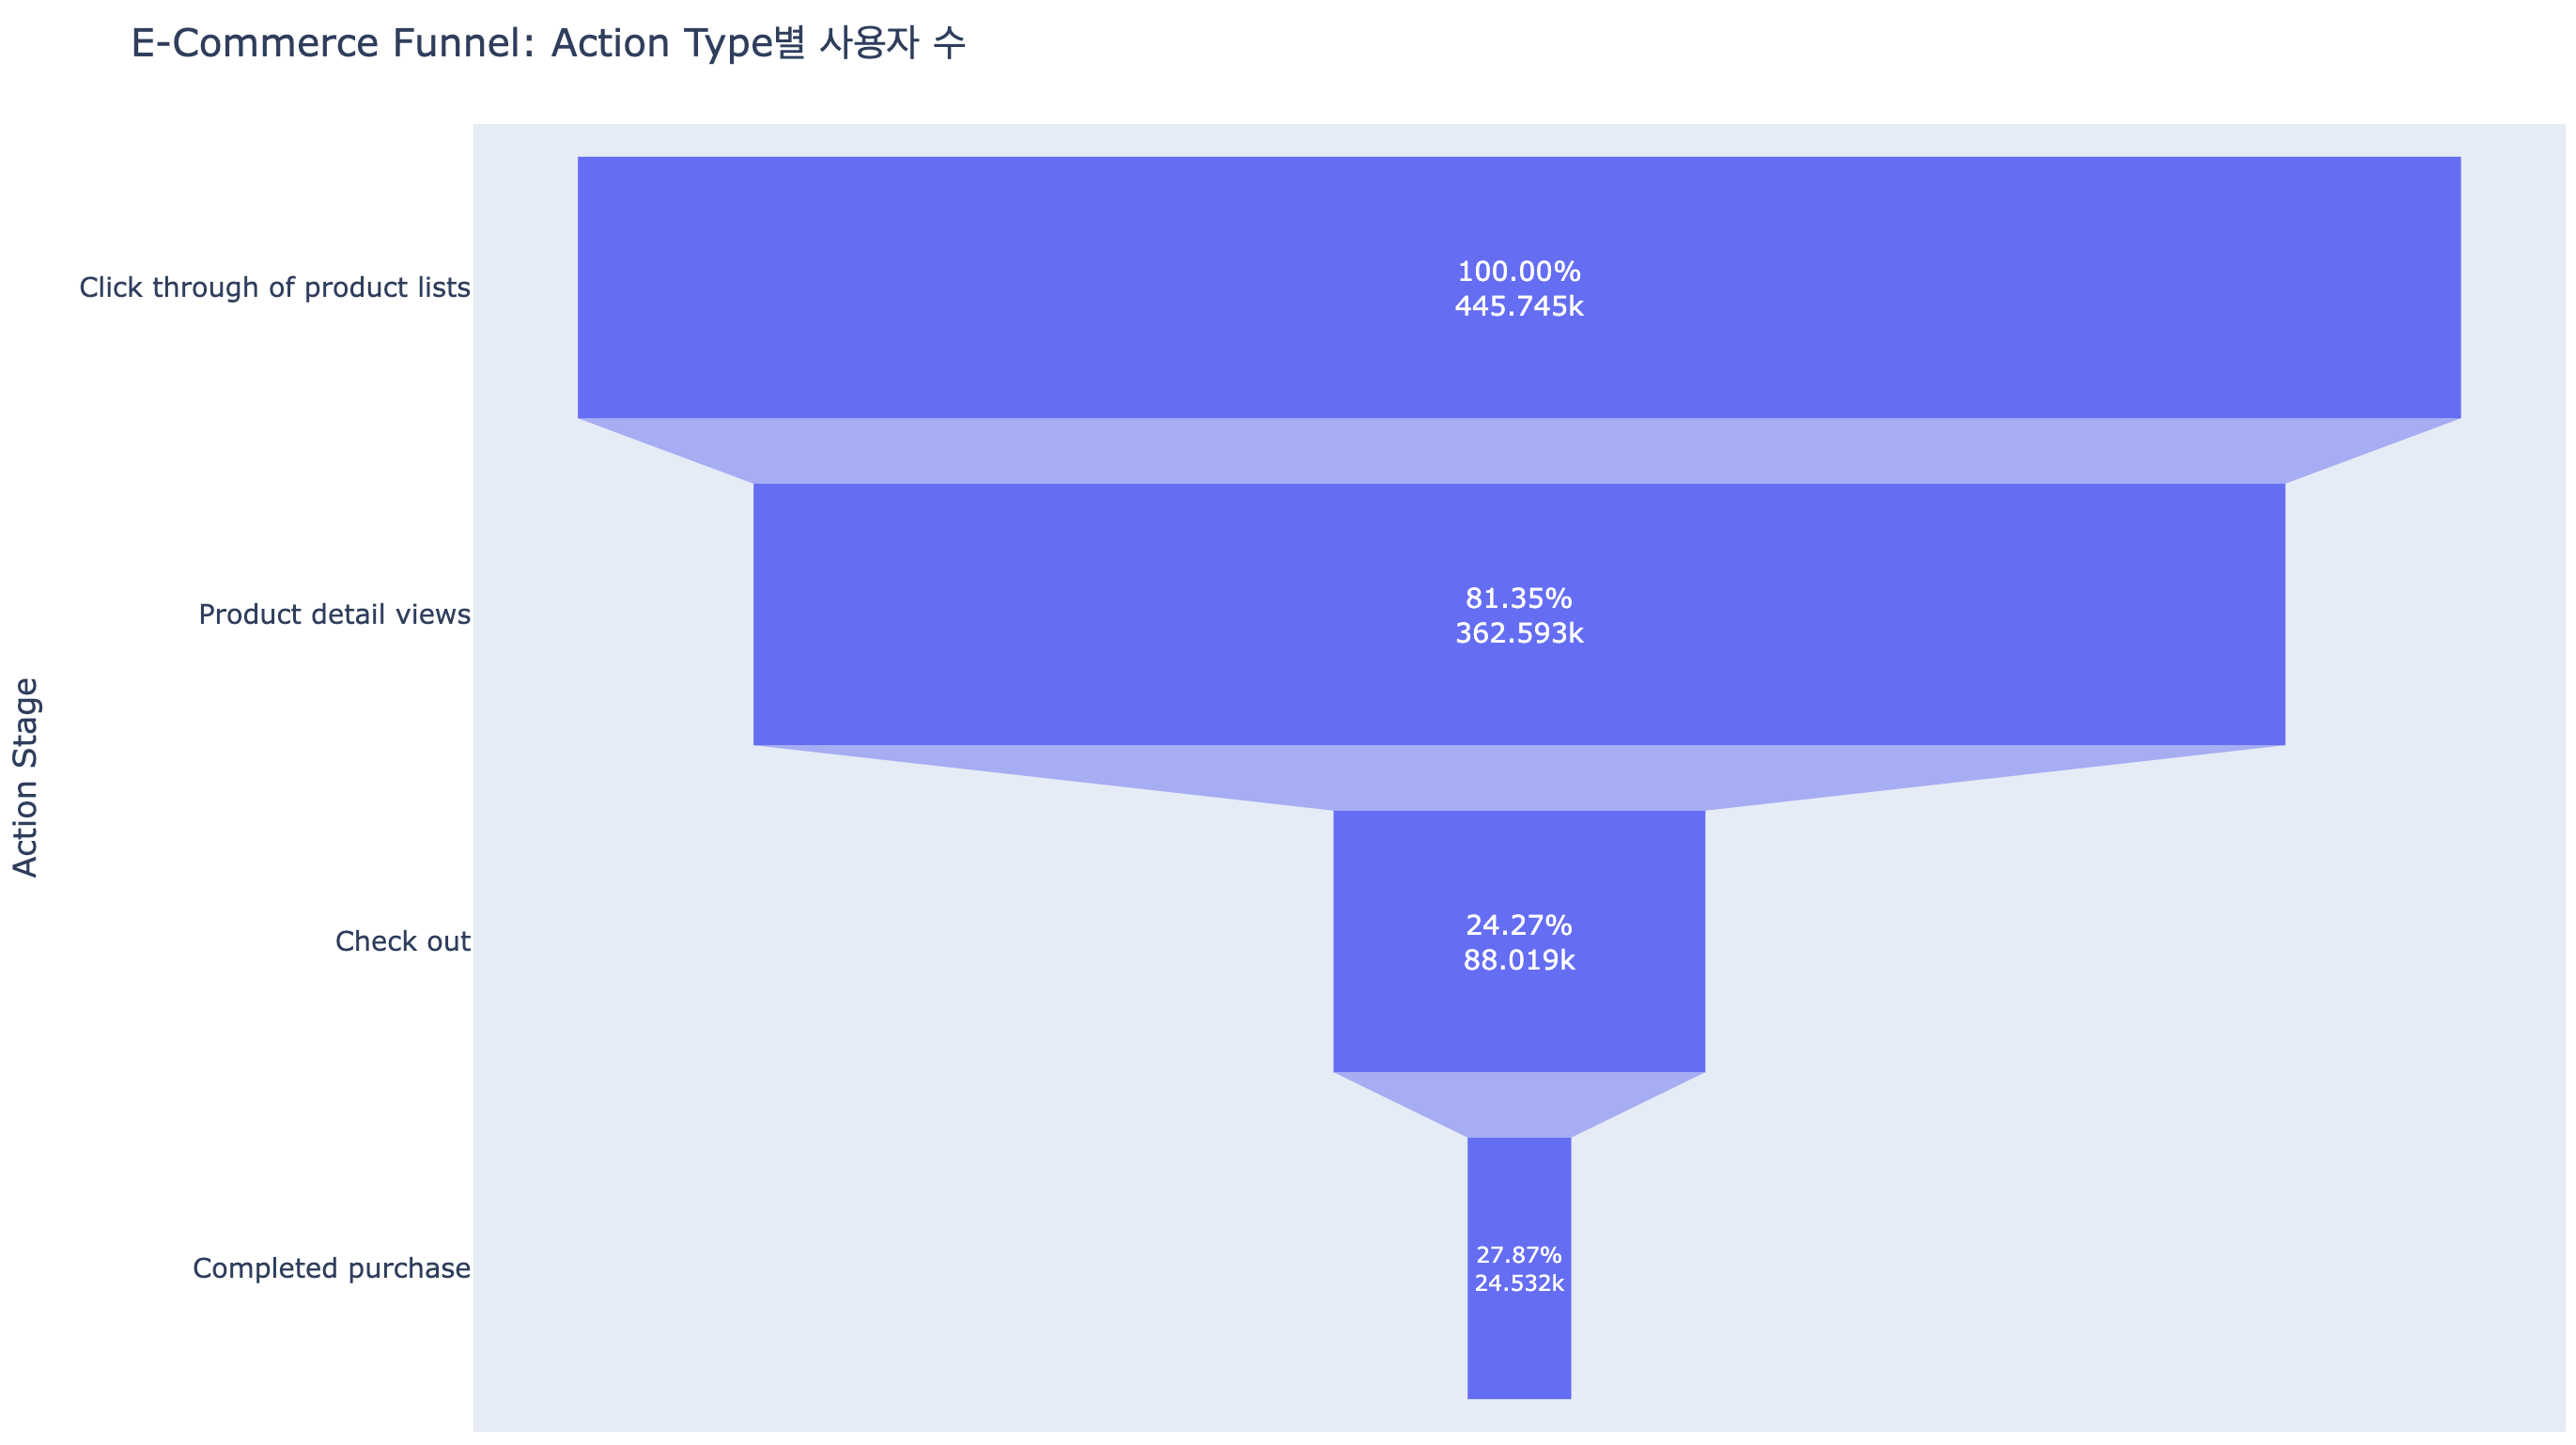

### 결과 : `가설 옳음`

- Product detail views(상품 상세 조회)에서 Check out(결제 단계 진입)에서의 전환율이 가장 크게 저하했다.
- 상세 조회 단계까지 온 사용자 4명 중 3명은 결제 단계로 넘어가지 않았다.
- 결제 단계 자체에서의 이탈률이 가장 높은 것이 맞고, 결제 단계에서 실제 결제 완료까지 넘어가는 단계에서의 이탈률 또한 굉장히 높은 것을 알 수 있다.
- 따라서 두 단계 모두 이탈 방지를 위한 비즈니스 액션이 필요해보인다.

## 2. 유료 광고 트래픽 사용자는 Organic보다 구매율이 낮을 것이다.
- 주요 지표 : `trafficSoure.medium`, `totals.transactions`
- 전환율 = 구매가 발생한 세션 수 / 전체 세션 수

In [5]:
hypo2_df = df.copy()

# transaction 값이 숫자가 아닌 경우 처리
hypo2_df['totals.transactions'] = pd.to_numeric(hypo2_df['totals.transactions'], errors='coerce').fillna(0)

# 전환 여부 컬럼 생성: 1회 이상 구매했으면 True
hypo2_df['is_converted'] = hypo2_df['totals.transactions'] > 0

# 전환율 계산: 유입경로(medium)별 세션 수, 구매 수, 전환율
conversion_summary = (
    hypo2_df.groupby('trafficSource.medium')['is_converted']
      .agg(['count', 'sum'])  # count: 세션 수, sum: 전환 세션 수
      .rename(columns={'count': 'total_sessions', 'sum': 'converted_sessions'})
).reset_index()

conversion_summary['conversion_rate'] = conversion_summary['converted_sessions'] / conversion_summary['total_sessions']

# 결과 확인
conversion_summary = conversion_summary.sort_values(by='conversion_rate', ascending=False)

conversion_summary

,trafficSource.medium,total_sessions,converted_sessions,conversion_rate
0,(none),371467,8742,0.023534
4,cpm,6184,141,0.022801
3,cpc,13079,243,0.018579
5,organic,234381,2126,0.009071
1,(not set),117,1,0.008547
6,referral,262022,290,0.001107
2,affiliate,16403,9,0.000549


- 시각화

/var/folders/l3/cq8y8n3s03v315zt58m2zrv80000gn/T/ipykernel_15360/1403138160.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


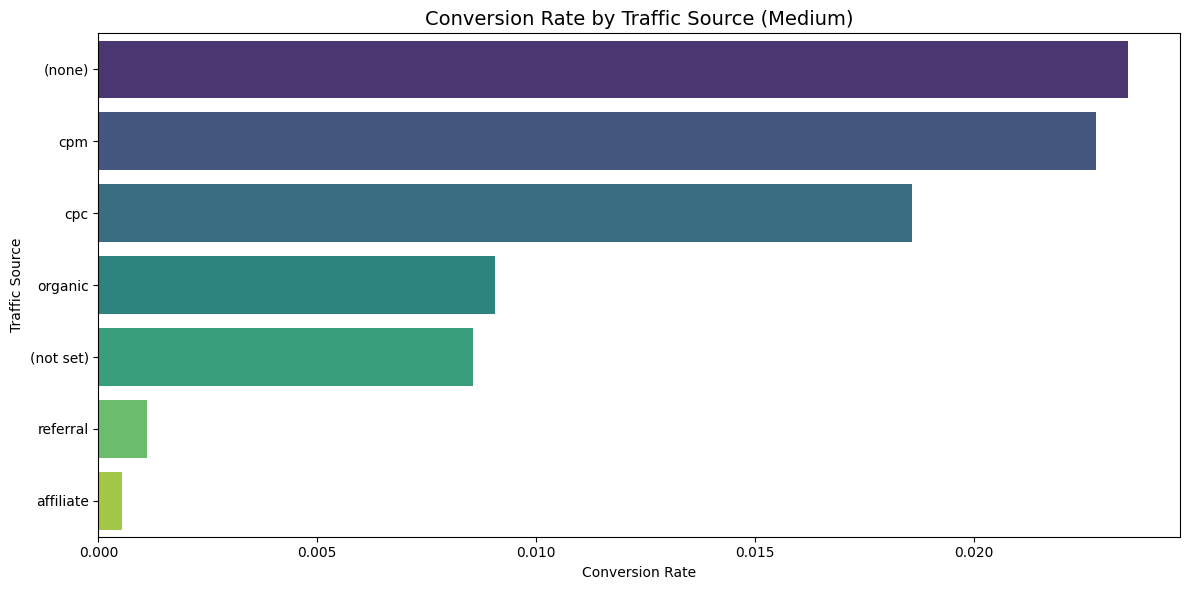

In [8]:
plt.figure(figsize=(12, 6))
sns.barplot(
    data=conversion_summary,
    x='conversion_rate',
    y='trafficSource.medium',
    palette='viridis'  # 원하는 색상 팔레트
)
plt.title('Conversion Rate by Traffic Source (Medium)', fontsize=14)
plt.xlabel('Conversion Rate')
plt.ylabel('Traffic Source')
plt.tight_layout()
plt.show()

### 결과 : `가설 틀림`

- Organic(자연 검색)을 통해 사이트를 방문한 사용자는 유료 광고(cpc, cpm, affiliate)에 비해 방문수(total_sessions)는 높지만, 실제 매출에 기여한 정도를 확인해보면 유료광고를 통해 유입된 사용자의 평균 전환율이 organic보다 높은 것을 알 수 있었다.
    - 평균 전환율 : **유료광고(cpc, cpm, affiliate) ≒ 1.4%**, **organic ≒ 0.91%**
- 대신 cpc, cpm은 전환율이 높지만 affiliate(제휴 마케팅 광고)의 전환율은 매우 낮기 때문에, 광고별 품질 및 콘텐츠 검토가 필요하다.

## 3. 첫 방문자는 재방문자보다 전환율이 낮을 것이다.
- 주요 지표 : `visitNumber`, `totals.transactions`

In [12]:
hypo3_df = df.copy()

# 구매 여부 컬럼 생성
hypo3_df['totals.transactions'] = pd.to_numeric(hypo3_df['totals.transactions'], errors='coerce').fillna(0)
hypo3_df['is_converted'] = hypo3_df['totals.transactions'] > 0

# 방문자 유형 컬럼 생성: 첫 방문 vs 재방문
hypo3_df['visitor_type'] = hypo3_df['visitNumber'].apply(lambda x: 'first_visit' if x == 1 else 'returning_visit')

# 전환율 집계
conversion_by_visitor_type = (
    hypo3_df.groupby('visitor_type')['is_converted']
      .agg(['count', 'sum'])  # count: 총 세션 수, sum: 전환된 세션 수
      .rename(columns={'count': 'total_sessions', 'sum': 'converted_sessions'})
).reset_index()

conversion_by_visitor_type['conversion_rate'] = (
    conversion_by_visitor_type['converted_sessions'] / conversion_by_visitor_type['total_sessions']
)

conversion_by_visitor_type

,visitor_type,total_sessions,converted_sessions,conversion_rate
0,first_visit,703060,4475,0.006365
1,returning_visit,200593,7077,0.035280


- 시각화

/var/folders/l3/cq8y8n3s03v315zt58m2zrv80000gn/T/ipykernel_15360/448651052.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


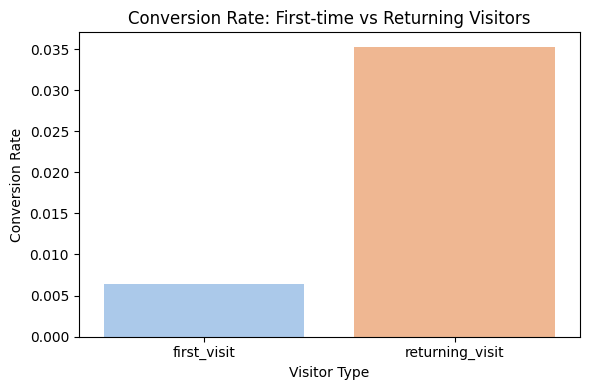

In [13]:
# 그래프를 그리기 위해 인덱스 초기화
conversion_by_visitor_type = conversion_by_visitor_type.reset_index()

# 시각화
plt.figure(figsize=(6, 4))
sns.barplot(
    data=conversion_by_visitor_type,
    x='visitor_type',
    y='conversion_rate',
    palette='pastel'
)
plt.title('Conversion Rate: First-time vs Returning Visitors')
plt.xlabel('Visitor Type')
plt.ylabel('Conversion Rate')
plt.tight_layout()
plt.show()

### 결과 : `가설 옳음`

- 재방문자의 전환율이 첫 방문자의 전환율보다 압도적으로 높은 것을 알 수 있으며 이로써 가설은 옳다는 것을 확인할 수 있다.
- 첫 방문자는 탐색 중심으로 제품, 가격, 신뢰도 등을 파악하기 위해 사이트를 둘러보는 수준이 많지만, 재방문자는 구매 의도가 뚜렷한 경우가 많다고 판단
- 전환 가능성이 높은 고객은 재방문자라는 인사이트를 도출할 수 있었으며 재방문자를 위한 리타겟팅, 쿠폰제공, 장바구니 리마인드 마케팅 등이 효과적일 수 있다.

## 4. 저녁/주말에는 전환율이 높을 것이다.
- 주요 지표 : `date`, `hour`, `totals.transactions`

In [19]:
hypo4_df = df.copy()

# 구매 여부 컬럼 생성
hypo4_df['totals.transactions'] = pd.to_numeric(hypo4_df['totals.transactions'], errors='coerce').fillna(0)
hypo4_df['is_converted'] = hypo4_df['totals.transactions'] > 0

# 시간대 분류
hypo4_df['hour'] = hypo4_df['visitStartTime'].apply(lambda x : pd.to_datetime(x, unit='s').hour)
hypo4_df['time_of_day'] = hypo4_df['hour'].apply(
    lambda x: 'evening' if 18 <= x <= 23 else ('daytime' if 9 <= x <= 17 else 'late_night')
)

# 요일 분류
hypo4_df['date'] = pd.to_datetime(hypo4_df['date'], format='%Y%m%d', errors='coerce')
hypo4_df['day_of_week'] = hypo4_df['date'].dt.dayofweek  # Monday=0, Sunday=6
hypo4_df['week_period'] = hypo4_df['day_of_week'].apply(lambda x: 'weekend' if x >= 5 else 'weekday')

# 전환율 집계: 시간대 기준
conversion_by_time = (
    hypo4_df.groupby('time_of_day')['is_converted']
      .agg(['count', 'sum'])
      .rename(columns={'count': 'total_sessions', 'sum': 'converted_sessions'})
).reset_index()

conversion_by_time['conversion_rate'] = conversion_by_time['converted_sessions'] / conversion_by_time['total_sessions']

# 전환율 집계: 요일 기준
conversion_by_week = (
    hypo4_df.groupby('week_period')['is_converted']
      .agg(['count', 'sum'])
      .rename(columns={'count': 'total_sessions', 'sum': 'converted_sessions'})
).reset_index()

conversion_by_week['conversion_rate'] = conversion_by_week['converted_sessions'] / conversion_by_week['total_sessions']

In [20]:
print("시간대별 전환율")
conversion_by_time.sort_values(by='conversion_rate', ascending=False)

시간대별 전환율


,time_of_day,total_sessions,converted_sessions,conversion_rate
1,evening,265091,4982,0.018794
2,late_night,280524,2971,0.010591
0,daytime,358038,3599,0.010052


### 결과 : `가설 옳음`

- 저녁 시간대(evening)의 전환율이 가장 높으면서 시간대별 전환율에 대한 가설은 옳은 것을 알 수 있다.

In [23]:
print("평일/주말 전환율")
conversion_by_week.sort_values(by='conversion_rate', ascending=False)

평일/주말 전환율


,week_period,total_sessions,converted_sessions,conversion_rate
0,weekday,705647,9821,0.013918
1,weekend,198006,1731,0.008742


### 결과 : `가설 틀림`

- 주말의 전환율이 오히려 평일보다 낮으면서 가설이 틀렸음을 알 수 있다.

/var/folders/l3/cq8y8n3s03v315zt58m2zrv80000gn/T/ipykernel_15360/3132298595.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=conversion_by_time_reset, x='time_of_day', y='conversion_rate', palette='Blues')


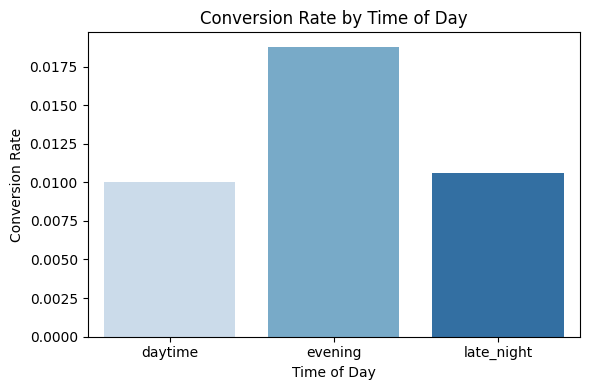

/var/folders/l3/cq8y8n3s03v315zt58m2zrv80000gn/T/ipykernel_15360/3132298595.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=conversion_by_week_reset, x='week_period', y='conversion_rate', palette='Oranges')


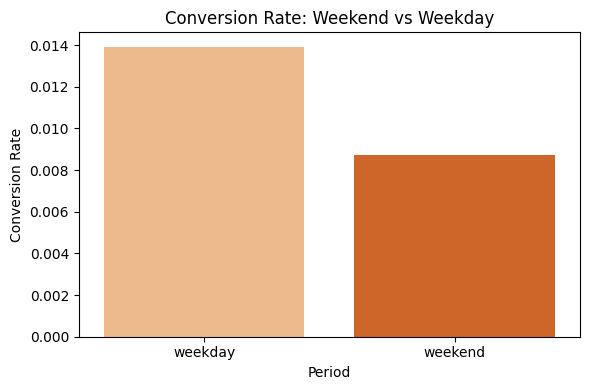

In [22]:
# 시간대 시각화
conversion_by_time_reset = conversion_by_time.reset_index()
plt.figure(figsize=(6, 4))
sns.barplot(data=conversion_by_time_reset, x='time_of_day', y='conversion_rate', palette='Blues')
plt.title('Conversion Rate by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Conversion Rate')
plt.tight_layout()
plt.show()

# 주말/평일 시각화
conversion_by_week_reset = conversion_by_week.reset_index()
plt.figure(figsize=(6, 4))
sns.barplot(data=conversion_by_week_reset, x='week_period', y='conversion_rate', palette='Oranges')
plt.title('Conversion Rate: Weekend vs Weekday')
plt.xlabel('Period')
plt.ylabel('Conversion Rate')
plt.tight_layout()
plt.show()

- 저녁 시간대에는 사용자들이 비교적 여유 있는 시간에 구매 전환을 더 많이 하는 경향을 파악할 수 있었다.
- 예상과 달리 주말 시간대의 트래픽, 전환율은 모두 평일에 비해 낮았는데, 탐색 및 휴식 목적일 가능성이 있을 수 있다고 판단된다.
- 광고 예산 및 마케팅 메세지를 저녁 및 평일 시간대에 집중시키고, 주말 시간대에 대한 타임제 할인 혜택 등을 도입하는 전략을 세울 수 있겠다.

## 5. 장바구니에 상품을 추가하고 구매를 하지 않은 사람이 많을 것이다.
- 주요 지표 : `hits.eCommerceAction.action_type`, `fullVisitorId`
- 장바구니에 상품을 추가한 사용자 중, 실제로 구매하지 않은 사용자와 구매한 사용자의 비율 비교

In [32]:
def extract_cart_purchase_flags(df):
    def get_action_types(hits_list):
        if not isinstance(hits_list, list):
            return []
        action_types = []
        for hit in hits_list:
            ecom = hit.get("eCommerceAction", {})
            if isinstance(ecom, dict):
                action_type = ecom.get("action_type")
                if action_type is not None:
                    action_types.append(int(action_type))
        return action_types

    # 1. 유저별로 action_type 추출
    df['action_types'] = df['hits'].apply(get_action_types)

    # 2. 유저 단위로 통합 (fullVisitorId 기준)
    user_action_df = df.groupby('fullVisitorId')['action_types'].sum().reset_index()

    # 3. 플래그 추가
    user_action_df['added_to_cart'] = user_action_df['action_types'].apply(lambda x: 3 in x)
    user_action_df['purchased'] = user_action_df['action_types'].apply(lambda x: 6 in x)

    return user_action_df[['fullVisitorId', 'added_to_cart', 'purchased']]

In [33]:
cart_1_df = extract_cart_purchase_flags(batch_1_df)
cart_2_df = extract_cart_purchase_flags(batch_2_df)
cart_3_df = extract_cart_purchase_flags(batch_3_df)
cart_4_df = extract_cart_purchase_flags(batch_4_df)
cart_5_df = extract_cart_purchase_flags(batch_5_df)
cart_6_df = extract_cart_purchase_flags(batch_6_df)
cart_7_df = extract_cart_purchase_flags(batch_7_df)
cart_8_df = extract_cart_purchase_flags(batch_8_df)
cart_9_df = extract_cart_purchase_flags(batch_9_df)

In [38]:
all_user_carts = pd.concat([
    cart_1_df, cart_2_df, cart_3_df,
    cart_4_df, cart_5_df, cart_6_df,
    cart_7_df, cart_8_df, cart_9_df
], ignore_index=True)

# 중복된 사용자 제거 (동일 사용자 여러 배치에 있을 수 있음 → 구매/장바구니 유무는 합쳐야 함)
final_user_carts = (
    all_user_carts.groupby("fullVisitorId")
    .agg({
        "added_to_cart": "max",  # True가 하나라도 있으면 True
        "purchased": "max"
    })
    .reset_index()
)

summary = (
    final_user_carts
    .groupby(['added_to_cart', 'purchased'])
    .size()
    .reset_index(name='user_count')
)

summary['percent'] = summary['user_count'] / summary['user_count'].sum() * 100

summary.sort_values('user_count', ascending=False)

,added_to_cart,purchased,user_count,percent
0,False,False,677298,94.302697
2,True,False,30846,4.294802
3,True,True,9242,1.286798
1,False,True,831,0.115703


- 시각화

/var/folders/l3/cq8y8n3s03v315zt58m2zrv80000gn/T/ipykernel_15360/2540386523.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary, x='group', y='percent', palette='pastel')


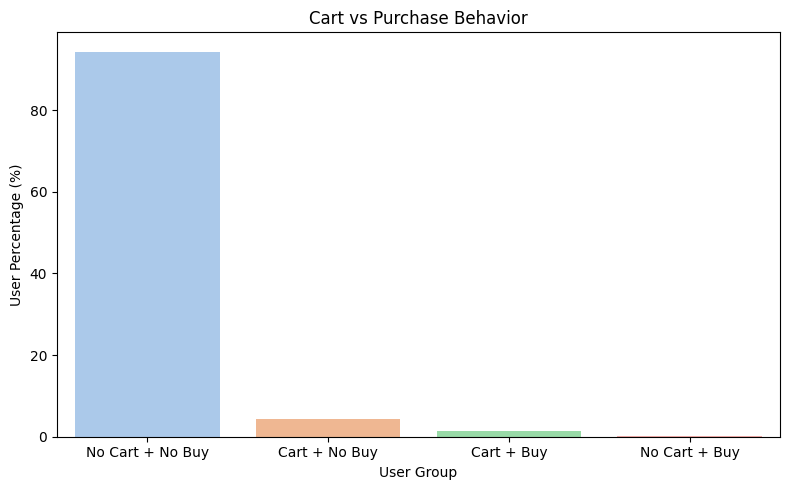

In [41]:
# 보기 좋게 문자열로 그룹 이름 생성
summary['group'] = summary.apply(
    lambda row: f"{'Cart' if row['added_to_cart'] else 'No Cart'} + {'Buy' if row['purchased'] else 'No Buy'}",
    axis=1
)

summary = summary.sort_values('percent', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(data=summary, x='group', y='percent', palette='pastel')
plt.title("Cart vs Purchase Behavior")
plt.ylabel("User Percentage (%)")
plt.xlabel("User Group")
plt.tight_layout()
plt.show()

### 결과 : `가설 옳음`

- 장바구니에 상품을 담은 사용자(30,846+9,242=40,088) 중 비구매자(30,846/40,088*100)은 약 76.9%로 장바구니에 상품을 담은 사용자 중 구매자보다 현저히 높은 비율을 보여준다.
- 장바구니를 거치고도 이탈한 사람 수(30,846)가 구매까지 한 사람 수(9,242)보다 약 3.3배가량 높은 수치를 보여준다.
- 장바구니에 대한 리마인드 이메일 혹은 알림을 주거나, 장바구니에 담은 상품에 대한 보존 기능 강화, 장바구니에서 구매 완료 단계까지의 장벽을 제거하는 등의 전략을 취할 수 있을 것.

## 6. 모바일 사용자보다 데스크탑 사용자의 전환율이 높을 것이다.
- 주요 지표 : `device.deviceCategory`, `totals.transactions`

In [28]:
hypo6_df = df.copy()

# 구매 여부 플래그 생성
hypo6_df['totals.transactions'] = pd.to_numeric(hypo6_df['totals.transactions'], errors='coerce').fillna(0)
hypo6_df['is_converted'] = hypo6_df['totals.transactions'] > 0

# 전환율 집계: device.deviceCategory 기준
conversion_by_device = (
    hypo6_df.groupby('device.deviceCategory')['is_converted']
      .agg(['count', 'sum'])
      .rename(columns={'count': 'total_sessions', 'sum': 'converted_sessions'})
).reset_index()

conversion_by_device['conversion_rate'] = (
    conversion_by_device['converted_sessions'] / conversion_by_device['total_sessions']
)

# 정렬 및 출력
conversion_by_device = conversion_by_device.sort_values(by='conversion_rate', ascending=False)

conversion_by_device

,device.deviceCategory,total_sessions,converted_sessions,conversion_rate
0,desktop,664479,10528,0.015844
2,tablet,30449,168,0.005517
1,mobile,208725,856,0.004101


- 시각화

/var/folders/l3/cq8y8n3s03v315zt58m2zrv80000gn/T/ipykernel_15360/3770898500.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=conversion_by_device, x='device.deviceCategory', y='conversion_rate', palette='Set2')


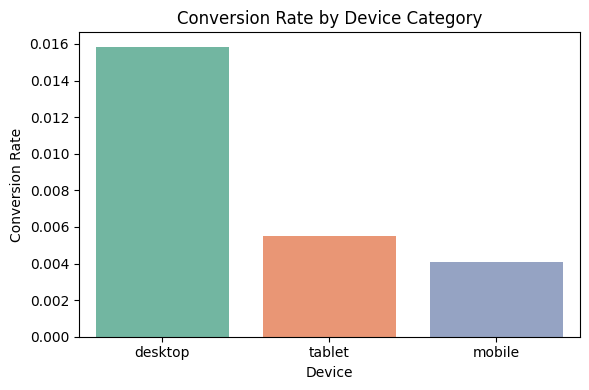

In [29]:
plt.figure(figsize=(6, 4))
sns.barplot(data=conversion_by_device, x='device.deviceCategory', y='conversion_rate', palette='Set2')
plt.title('Conversion Rate by Device Category')
plt.xlabel('Device')
plt.ylabel('Conversion Rate')
plt.tight_layout()
plt.show()

### 결과 : `가설 옳음`

- 실제로 데스크탑 사용자의 전환율(conversion_rate)이 모바일보다 약 4배가량 높다는 것을 알 수 있다.
- 데스크탑 사용자는 화면 크기, 입력 편의성, 탐색 효율성 등에서 유리하여 구매 행동에 긍정적 영향을 미칠 수 있다.
- 반면 모바일은 탐색은 활발하지만 실제 구매로는 잘 이어지지 않았다. 이는 결제 UX, 로그인/회원가입, 느린 속도, 제한된 화면 등이 장벽일 가능성이 있다.